# **1. Overview**
This Jupyter notebook covers various steps of implementing CNN architecture in order to build image classification model that detects Covid-19 from x-ray images.

Following code section import all the important Python modules required for this exercise.

In [1]:
# https://ai.plainenglish.io/best-performance-tuning-practices-for-pytorch-3ef06329d5fe
import gc
import time
import os
import random
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import zipfile
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import *
from sklearn.model_selection import KFold

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

num_workers = 4
batch_size = 32
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
categories = ['COVID19', 'NORMAL', 'PNEUMONIA']
num_classes = len(categories)
splits = ['train', 'val', 'test']
#DATA_PATH = r"C:\Gunther\Datasets\Covid19DLH\Data"
#model_path = r"C:\Gunther\OneDrive - University of Illinois - Urbana\Python\DLH\COVID-19-CHEST-X-RAY-IMAGE-CLASSISICATION"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}')

You are using cuda


# **2. Load data from external source**



1.   Download the dataset from external datasource: https://www.kaggle.com/prashant268/chest-xray-covid19-pneumonia)
2.   Upload the dataset in zip format to google drive and mount the drive in Colab environment
1.   Copy the zip file from mount drive to Colab folder
2.   Unzip the file
1.   Set the data path to unzipped file location








In [2]:
#!cp '/content/drive/MyDrive/chest-xray-data/Covid.zip' '/content'
#local_zip = '/content/Covid.zip'
#zip_ref = zipfile.ZipFile(local_zip, 'r')
#zip_ref.extractall('/content')
#zip_ref.close()
DATA_PATH = "Covid"
model_path = "Covid"

# **3. Image count statistics**

Dataset contains 6432 images of seggreated into three different types - 

1. Normal\Healthy person x-ray image, 2. Pneumonia patient x-ray image, 3. Covid-19 patient x-ray image

In [3]:
def show_dataset(data_path=DATA_PATH):
    df = pd.DataFrame(columns = ['code'] + splits, index = categories)
    for row in categories:
        for col in splits:
            df.loc[row,col] = int(len(os.listdir(os.path.join(data_path, col+'/'+row))))
    df['total'] = df.sum(axis=1).astype(int)
    df.loc['TOTAL'] = df.sum(axis=0).astype(int)
    df['code'] = ['0', '1', '2','']
    print(df)
    return df
df_dataset = show_dataset()

(1108, 2991, 403)
(238, 642, 87)
          code train  val test  total
COVID19      0   403   86   87    576
NORMAL       1  1108  237  238   1583
PNEUMONIA    2  2991  640  642   4273
TOTAL           4502  963  967   6432


# **4. Image augmentation and load data**

Use python's transform module to perform following image augmentation steps:

1.   Resize the x-ray image to the image of shape(256, 256) uniformly
2.   Apply centercrop function to crop the center part of the image of shape (224, 224)
1.   Convert image to tensor
2.   Load train and test data using ImageFolder function
5.   Concatenate the train and test dataset




In [4]:
def load_data(data_path=DATA_PATH, num_workers=num_workers):
    transform_dict = {
        'model': transforms.Compose(
        [transforms.Resize(224),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         ])}
    train_data = datasets.ImageFolder(root=data_path + '/train', transform=transform_dict['model'])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_data = datasets.ImageFolder(root=data_path + '/val', transform=transform_dict['model'])
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_data = datasets.ImageFolder(root=data_path + '/test', transform=transform_dict['model'])
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_data, train_loader, val_data, val_loader, test_data, test_loader

train_data, train_loader, val_data, val_loader, test_data, test_loader = load_data()
dataset = torch.utils.data.ConcatDataset([train_data, val_data, test_data])

# **6. GPU**

Enable GPU capacity for model building exercise 

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

cuda:0
Using CUDA


# **7. Visualization**

Visulaize a batch of images representing train dataset

Sample images for training purpose:
tensor([2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
        1, 1, 2, 2, 0, 2, 2, 2])


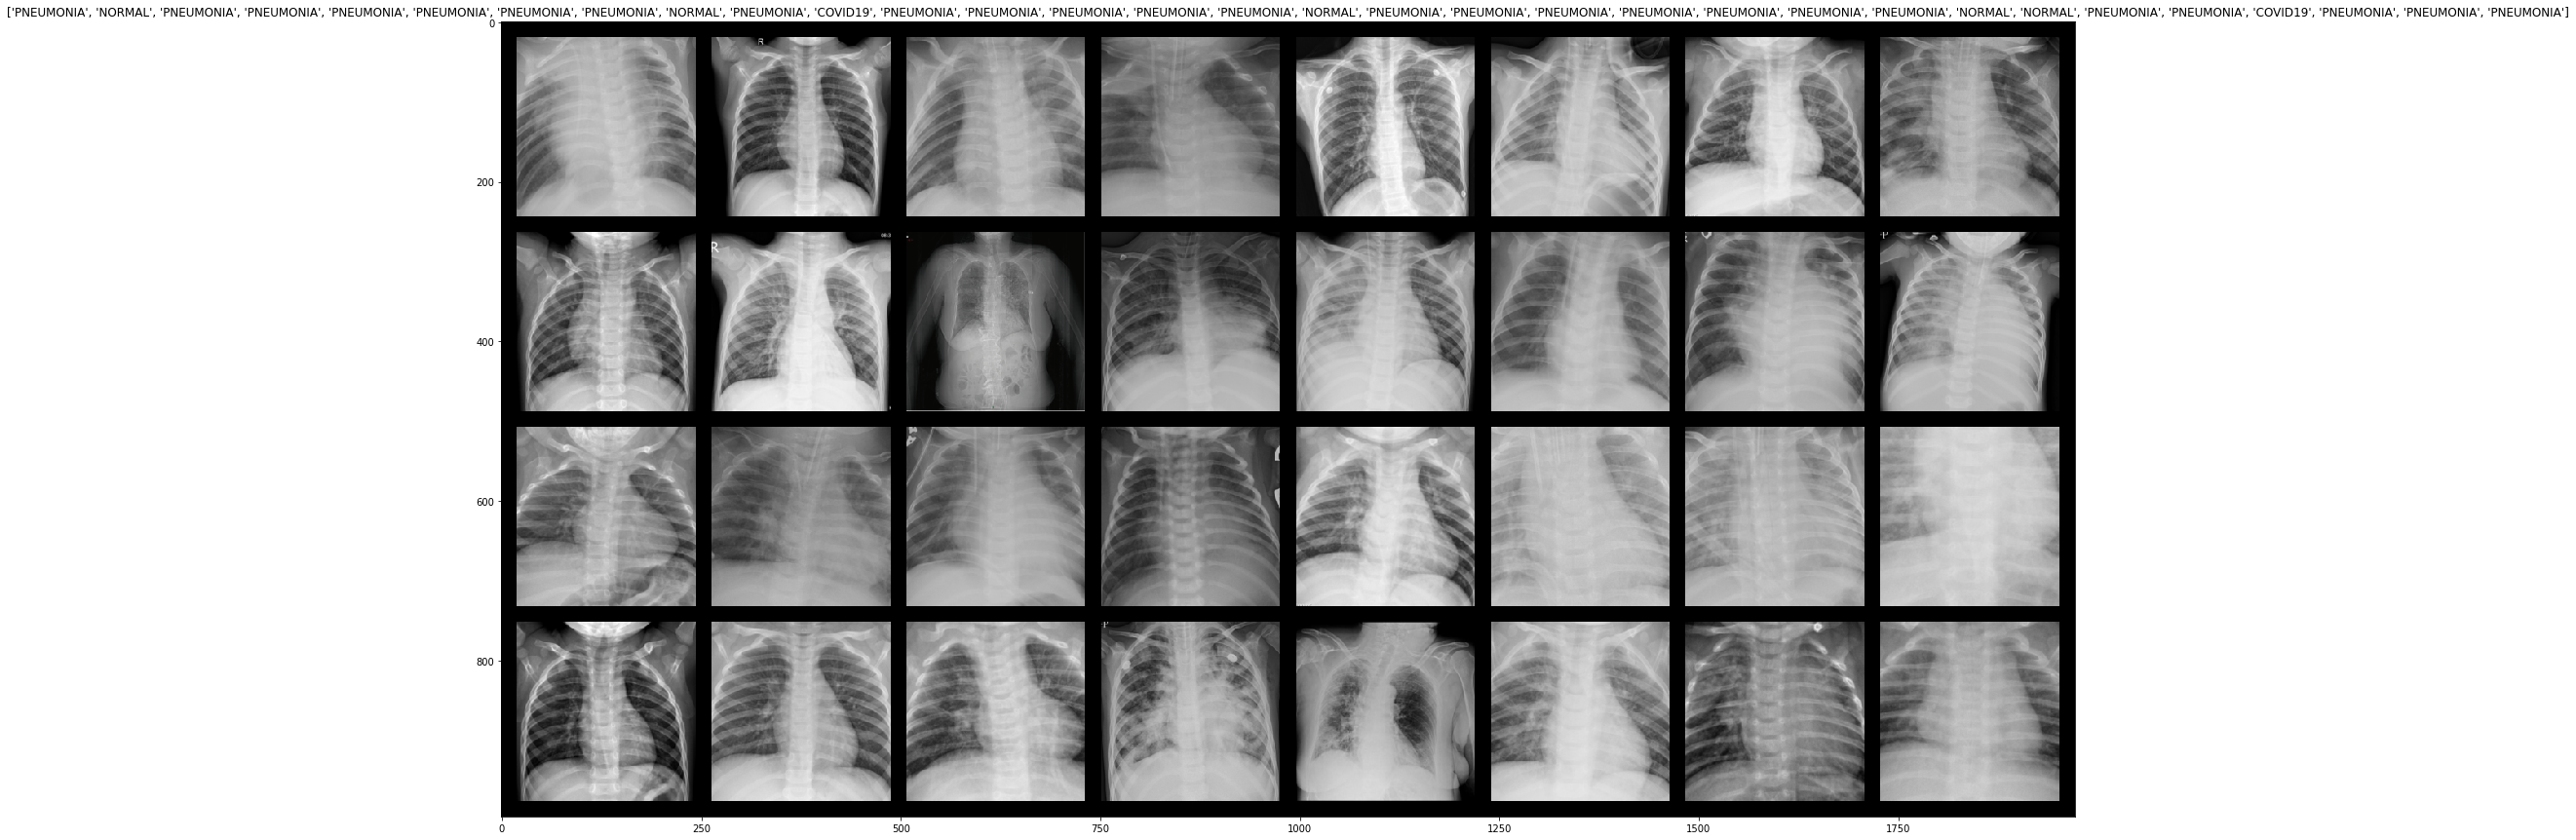

In [6]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    grid = torchvision.utils.make_grid(images, padding=20)
    print(labels)
    npgrid = grid.cpu().numpy()
    plt.figure(figsize=(30, 15))
    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')
    plt.title(label=["COVID19" if x==0  else ("NORMAL" if x == 1 else "PNEUMONIA") for x in labels])
    plt.show()

print(f'Sample images for training purpose:')
for i in range(1):
    show_batch_images(train_loader) 

# **8. Model Development**
# Load pre-trained model
For this image classification exercise, we leveraged following pre-trained models as a part of transfer learning approach:

1.   VGG16
2.   ResNet18
1.   ResNet50
1.   Inception



All the models have been loaded from the torchvision module. (https://pytorch.org/vision/stable/models.html)

By default, when we load a pretrained model all of the parameters have .requires_grad=True. But we want to train only the last layer hence we set the attribute requires_grad=False.


In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
    if model_name == "resnet18":
      model_ft = models.resnet18(pretrained=use_pretrained)
      set_parameter_requires_grad(model_ft, feature_extract)
      num_ftrs = model_ft.fc.in_features
      model_ft.fc = nn.Linear(num_ftrs, num_classes)
      input_size = 224
    
    elif model_name == "resnet50":
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg16":
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "inception":
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [8]:
pretrained_model, input_size = initialize_model("resnet50", num_classes, feature_extract=True, use_pretrained=True)

print(pretrained_model)

pretrained_model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Build simple CNN architecture

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 128, (3,3), padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(128, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear1 = nn.Linear(28 * 28 * 32, 512)
        self.dropout = nn.Dropout()
        self.linear2 = nn.Linear(512, 3)
    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

our_model = Net()

our_model.cuda()


Net(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=25088, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear2): Linear(in_features=512, out_features=3, bias=True)
)

In [10]:
def train_model(model,model_name,optimizer):
    model.to(device).train()
    t0 = time.time()
    df = pd.DataFrame(columns = ['model_name', 'epoch', 'loss'])
    print(f"Training the model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and {n_epochs} epochs \n")
    for epoch in range(n_epochs):
        curr_epoch_loss = 0.0
        for i, (data, target) in enumerate(train_loader):
            target = target.to(device)
            data = data.to(device)
            #print(data.shape)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            curr_epoch_loss += loss.detach().cpu().numpy()
        print(f"Epoch {epoch}:\t loss={curr_epoch_loss/(i+1):.5f} \t time={(time.time() - t0):.2f}s")
        df.loc[len(df)] = [model_name, epoch, curr_epoch_loss/(i+1)]
        gc.collect()
        torch.cuda.empty_cache()
    return model, df

our_model = our_model.to(device)
pretrained_model = pretrained_model.to(device)
model_name = 'DLH_team'
n_epochs = 5
learning_rate = 1e-2 
criterion = nn.CrossEntropyLoss()
optimizer_our_model = torch.optim.SGD(our_model.parameters(), lr=learning_rate)
optimizer_pretrained_model = torch.optim.SGD(pretrained_model.parameters(), lr=learning_rate)


In [11]:
#Our model
our_model, df_our_model_epochs = train_model(our_model,model_name='DLH_Team',optimizer=optimizer_our_model)

#pretrained model
pretrained_model, df_pretrained_epochs = train_model(pretrained_model,model_name='resnet50',optimizer=optimizer_pretrained_model)

Training the model DLH_Team with 4502 samples and 5 epochs 

Epoch 0:	 loss=0.38986 	 time=58.16s
Epoch 1:	 loss=0.20896 	 time=117.35s
Epoch 2:	 loss=0.17503 	 time=175.60s
Epoch 3:	 loss=0.15004 	 time=235.11s
Epoch 4:	 loss=0.13441 	 time=294.05s
Training the model resnet50 with 4502 samples and 5 epochs 

Epoch 0:	 loss=0.43309 	 time=58.30s
Epoch 1:	 loss=0.26076 	 time=115.94s
Epoch 2:	 loss=0.23203 	 time=176.41s
Epoch 3:	 loss=0.21328 	 time=235.77s
Epoch 4:	 loss=0.20496 	 time=294.98s


# **9. Model validation**

**1st approach:**

Model validation technique has been used to evaluate the trained model using provided 15% validation data.



In [12]:
def validate_model(model,model_name):
    model.eval()
    print(f"Testing the model {model_name} with {df_dataset.loc['TOTAL', 'val']} samples \n")
    predictions, actuals = calc_pred_actual(model, val_loader)
    conf_matrix = create_confusion_matrix(predictions, actuals)
    df_val = calc_metrics(predictions, actuals, 'Test Results').astype(float)
    return df_val, conf_matrix

def calc_pred_actual(model, loader):
    model.eval()
    torch.manual_seed(seed)
    predictions, actuals = [], []
    labels = [0, 1, 2]
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            Y_pred_orig = model(data)
            _, Y_pred_tag = torch.max(Y_pred_orig, dim = 1)
            Y_pred_tag = Y_pred_tag.detach().cpu().numpy()
            Y_pred_tag = Y_pred_tag.reshape(len(Y_pred_tag), 1).astype('int8')
            Y_test = target.detach().cpu().numpy()
            Y_test = Y_test.reshape(len(Y_test), 1).astype('int8')
            predictions.append(Y_pred_tag)
            actuals.append(Y_test)
            gc.collect()
            torch.cuda.empty_cache()
    return predictions, actuals

def create_confusion_matrix(preds, y_test):
    ylist, predlist = [], []
    for pred in preds:
        for item in pred:
            predlist.append(int(item))
    for y in y_test:
        for item in y:
            ylist.append(int(item))
    data_dict = {'y_Actual':    ylist, 'y_Predicted': predlist}
    df = pd.DataFrame(data_dict, columns=['y_Actual','y_Predicted'])
    cm = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['ACTUAL'], colnames=['PREDICTED'])
    return cm

def calc_metrics(predictions, actuals, row):
    df = pd.DataFrame(columns =metrics)
    Y_pred = np.concatenate(predictions, axis=0)
    Y_test = np.concatenate(actuals, axis=0)
    df.loc[row, 'Accuracy'] = accuracy_score(Y_test, Y_pred)
    df.loc[row, 'Precision'] = precision_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'Recall'] = recall_score(Y_test, Y_pred, average="macro")
    df.loc[row, 'F1-score'] = f1_score(Y_test, Y_pred, average="macro")
    return df


In [13]:
# Our model
validation_our_model_results, conf_matrix_our_model_val = validate_model(our_model,model_name='DLH_Team')
print(validation_our_model_results)
# Pretrained model
validation_pretrained_results, conf_matrix_pretrained_val = validate_model(pretrained_model,model_name='resNet50')
print(validation_pretrained_results)

Testing the model DLH_Team with 963 samples 

              Accuracy  Precision    Recall  F1-score
Test Results  0.935618   0.933951  0.899856  0.914244
Testing the model resNet50 with 963 samples 

              Accuracy  Precision    Recall  F1-score
Test Results  0.903427   0.909346  0.857975   0.87868


**2nd validation approach:**

Use k-fold cross validation technique to evaludate models as follows:
1.   Set k=5 to perform cross validation using 5 folds.
2.   Generate train and test data using random sampler for each fold.
1.   Perform forward propagation using pre-trained model 
2.   Calculate train loss and perform optimization with zero gradient
1.   Evaluation the model using test data
2.   Calculate accuracy measures such as accuracy score, precision, recall and F1-score.

In [14]:
from sklearn.model_selection import StratifiedKFold
def validate_model_kfold(model, model_name, k_folds):
    model.eval()
    print(f"Validating the model {model_name} with {df_dataset.loc['TOTAL', 'train']} samples and {k_folds}-folds \n")
    df = pd.DataFrame(columns = metrics)
    kfold = KFold(n_splits=k_folds, shuffle=True)
    for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
        train_kfold_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=train_subsampler)
        test_kfold_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, sampler=test_subsampler)
        predictions, actuals = calc_pred_actual(model, train_kfold_loader)
        conf_matrix = create_confusion_matrix(predictions, actuals)
        df_aux = calc_metrics(predictions, actuals, 'FOLD '+str(fold+1))
        df = df.append(df_aux)      
    df.loc['Average'] = df.mean(axis=0)
    print(df.astype(float))
    return df.astype(float), conf_matrix

In [15]:
# Our model
validation_our_model_results, conf_matrix_our_model_val = validate_model_kfold(our_model, model_name = 'DLH_Team', k_folds = 5)
#print(validation_our_model_results)
# Pretrained model
validation_pretrained_results, conf_matrix_pretrained_val = validate_model_kfold(pretrained_model, model_name = 'ResNet50', k_folds = 5)
#print(validation_our_model_results)

Validating the model DLH_Team with 4502 samples and 5-folds 

         Accuracy  Precision    Recall  F1-score
FOLD 1   0.947133   0.945227  0.934799  0.938874
FOLD 2   0.948494   0.945673  0.936590  0.939937
FOLD 3   0.949864   0.948525  0.939009  0.942820
FOLD 4   0.945977   0.943647  0.933002  0.937041
FOLD 5   0.946560   0.944616  0.934476  0.938392
Average  0.947606   0.945538  0.935575  0.939413
Validating the model ResNet50 with 4502 samples and 5-folds 

         Accuracy  Precision    Recall  F1-score
FOLD 1   0.907094   0.915603  0.864122  0.883604
FOLD 2   0.909232   0.918935  0.866538  0.886010
FOLD 3   0.906335   0.911741  0.864746  0.882127
FOLD 4   0.907307   0.917375  0.862271  0.883380
FOLD 5   0.903614   0.914288  0.858498  0.879461
Average  0.906717   0.915588  0.863235  0.882916


# **10. Final model accuracy result**

Choosing the model with best accuracy from validation phase and evaluate accuracy with 15% test dataset

In [16]:
def test_model(final_model,model_name):
    final_model.eval()
    print(f"Testing the model {model_name} with {df_dataset.loc['TOTAL', 'test']} samples \n")
    predictions, actuals = calc_pred_actual(final_model, test_loader)
    conf_matrix = create_confusion_matrix(predictions, actuals)
    df_test = calc_metrics(predictions, actuals, 'Test Results').astype(float)
    return df_test, conf_matrix

test_results, conf_matrix_test = test_model(our_model,model_name='DLH_Team')
print(test_results)


Testing the model DLH_Team with 967 samples 

              Accuracy  Precision    Recall  F1-score
Test Results  0.930714   0.932065  0.895472  0.910701


In [17]:
torch.save(our_model.state_dict(), os.path.join(model_path, 'our_model.pth'))

# **11. Visualization**

1.   Show the trend of train loss vs epoch count of each model 
2.   Show confusion matrix of final test dataset



In [18]:
def plot_epoch(df):
    _ = plt.plot(df['epoch'], df['loss'])
    plt.xlabel('Epoch') 
    plt.ylabel('Loss')
    _ = plt.title(label=f"Training loss vs epoch for model: {df.iloc[0,0]}", fontsize=15, color="darkblue")
    plt.show()

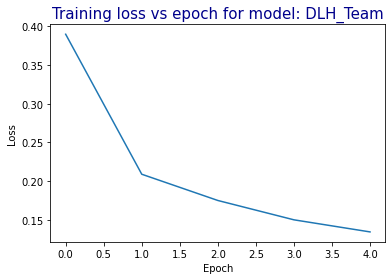

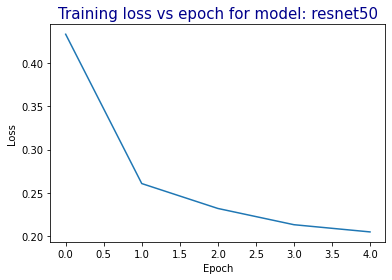

In [19]:
plot_epoch(df_our_model_epochs)
plot_epoch(df_pretrained_epochs)

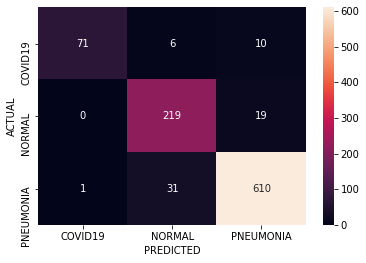

In [20]:
a = sn.heatmap(conf_matrix_test, annot=True, fmt='g', xticklabels=categories, yticklabels=categories)